In [1]:
from datasets import load_dataset
ds = load_dataset("KGraph/FB15k-237")
import json

with open("entity2wikidata.json", "r") as f:
    mid_info = json.load(f)

mid_to_name = {mid: data["label"] for mid, data in mid_info.items()}

c:\Users\Anaconda\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


import csv

from rdflib import Graph, URIRef
import re, unicodedata
# 1. Criar o grafo RDF
kg = Graph()
SPORT = {
    "/sports/",
    "/soccer/",
    "/olympics/",
}
def clean_name(name):
    # remover acentos
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode()
    # substituir espaços por _
    name = name.replace(" ", "_")
    # remover tudo que não for letra, número ou _
    name = re.sub(r"[^a-zA-Z0-9_]", "", name)
    return name

# 2. Adicionar as triplas do dataset
for item in ds['train']:
    parts = item['text'].split("\t")
    if len(parts) != 3:
        continue
    
    head, relation, tail = parts
    if not relation.startswith(tuple(SPORT)):
        continue
    head_name = mid_to_name.get(head, head)
    tail_name = mid_to_name.get(tail, tail)
    head = clean_name(head_name)
    tail = clean_name(tail_name)

    # criar URIs para cada elemento
    head_uri = URIRef(head)
    relation_uri = URIRef(relation)
    tail_uri = URIRef(tail)
    
    kg.add((head_uri, relation_uri, tail_uri))



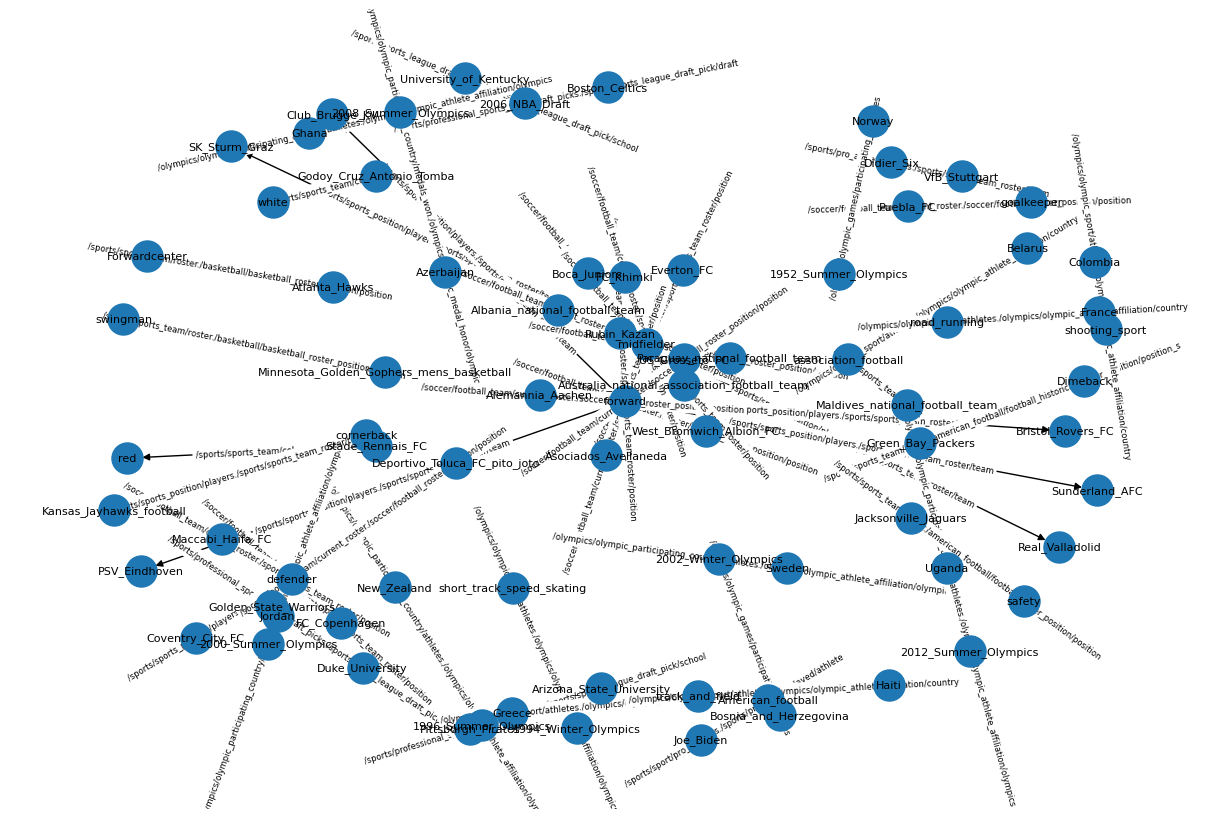

In [8]:
import networkx as nx
subgraph = list(kg)[:50]  # 50 triplas
import matplotlib.pyplot as plt

# Converter o RDFLib Graph para NetworkX
G = nx.DiGraph()

for s, p, o in subgraph:
    G.add_edge(str(s), str(o), label=str(p))
    

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(s, o): p for s, o, p in G.edges(data='label')}, font_size=6)
plt.show()

In [4]:
import spacy
from langdetect import detect

# Carregar modelo de português
nlp_pt = spacy.load("pt_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")


In [16]:
def analise(text,graph):
    idioma = detect(text)
    print("Idioma detectado:", idioma)

    if idioma == "pt":
        doc = nlp_pt(text)
    else:
        doc = nlp_en(text)

    palavras_distintas = []
    for token in doc:
        if token.text not in palavras_distintas:
            palavras_distintas.append(token.text)

    print("Palavras distintas:", palavras_distintas)
    entities = list()
    grupos = {}
    for token in doc:
        pos = token.pos_
        if pos not in grupos:
            grupos[pos] = set()  # set para evitar duplicados
        grupos[pos].add(token.text)

    # Converter sets para listas
    grupos = {pos: list(palavras) for pos, palavras in grupos.items()}

    print("\nPalavras agrupadas por grupo:")
    for pos, palavras in grupos.items():
        print(f"{pos}: {palavras}")
        for palavra in palavras:
            if palavra in graph.nodes:
                print(f" → A palavra '{palavra}' EXISTE.")
                entities.append(palavra)
            else:
                print(f" → A palavra '{palavra}' NÃO EXISTE.")
    print("\nEntidades:")
    for entity in doc.ents:
        print(entity.text, entity.label_)
        if entity.text in graph.nodes:
            print(f" → A entidade '{entity.text}' EXISTE.")
            entities.append(entity.text)
        else:
            print(f" → A entidade '{entity.text}' NÃO EXISTE.")
    return entities

In [21]:
entities = set()

In [22]:
text = input("Insira texto:")
while text!="exit":
    entities.update(analise(text,G))
    text = input("Insira texto:")

Idioma detectado: nl
Palavras distintas: ['Joe_Biden', 'lives', 'in', 'Belarus']

Palavras agrupadas por grupo:
PROPN: ['Belarus', 'Joe_Biden']
 → A palavra 'Belarus' EXISTE.
 → A palavra 'Joe_Biden' EXISTE.
VERB: ['lives']
 → A palavra 'lives' NÃO EXISTE.
ADP: ['in']
 → A palavra 'in' NÃO EXISTE.

Entidades:
Belarus GPE
 → A entidade 'Belarus' EXISTE.
